In [1]:
from src.torch_erg import load_pglib_opf as lp
from src.torch_erg.utils import laplacian_matrix
from src.torch_erg.samplers import GWGSampler, MHSampler
import torch
import numpy as np
import networkx as nx
import random as rnd

from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
# parsing the .m file into a suitable format, and perform some sanity checks
import matplotlib.pyplot as plt

from plots import *
from utils import *
from param_estimation import *

In [9]:
def random_tree_prufer(n):
    if n == 0:
        raise ValueError("n must be > 0")
    if n == 1:
        return nx.empty_graph(1)
    # genera sequenza di Prufer di lunghezza n-2
    seq = [random.randrange(n) for _ in range(n-2)]
    # costruisci l'albero da sequenza
    G = nx.from_prufer_sequence(seq)
    return G

def generate_tree(n_nodes):
    tree = random_tree_prufer(n_nodes)
    return nx.to_numpy_array(tree)

In [37]:
SOFT_CONN = True

input_graph = torch.tensor(generate_tree(30))

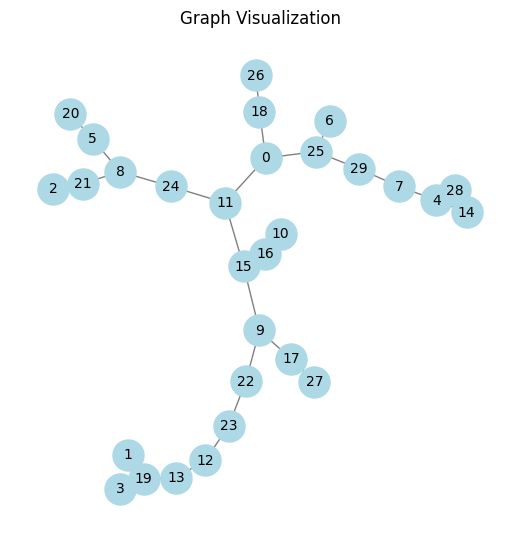

In [41]:
plot_graph(input_graph)

In [22]:
def avg_clustering_coeff(mtx):
    deg = torch.sum(mtx, dim=1)
    tri_diag = torch.diagonal(mtx @ mtx @ mtx) / 2

    valid = deg > 1
    local_clust = torch.zeros_like(deg)
    local_clust[valid] = tri_diag[valid] / (deg[valid] * (deg[valid] - 1))
    avg_clustering = torch.mean(local_clust[valid])
    #avg_clustering_coeff = nx.average_clustering(nx.from_numpy_array(mtx.numpy()))
    return avg_clustering

In [42]:
class MySampler(MHSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        ac = torch.linalg.eigvalsh(laplacian_matrix(mtx))[1]
        avg_degree = torch.sum(mtx, dim=1).mean()
        avg_clustering = avg_clustering_coeff(mtx)

        return(torch.stack([edges, triangles, ac, avg_degree, avg_clustering]))

betas = torch.tensor([0., 0., 0., 0., 0.], dtype=float)


alpha = 0.002
niter = 120000
min_change = 0.001
update_steps = 3

sampler = MySampler(backend="cuda")
obs = sampler.observables(input_graph)

params, graphs = sampler.param_run(graph=input_graph,
                      observables=obs,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

CUDA backend not available falling back to cpu


100%|██████████| 120000/120000 [01:03<00:00, 1880.02it/s]

number of accepted steps is:  26292
number of rejected samples:  93708
number of effective updates is:  8764


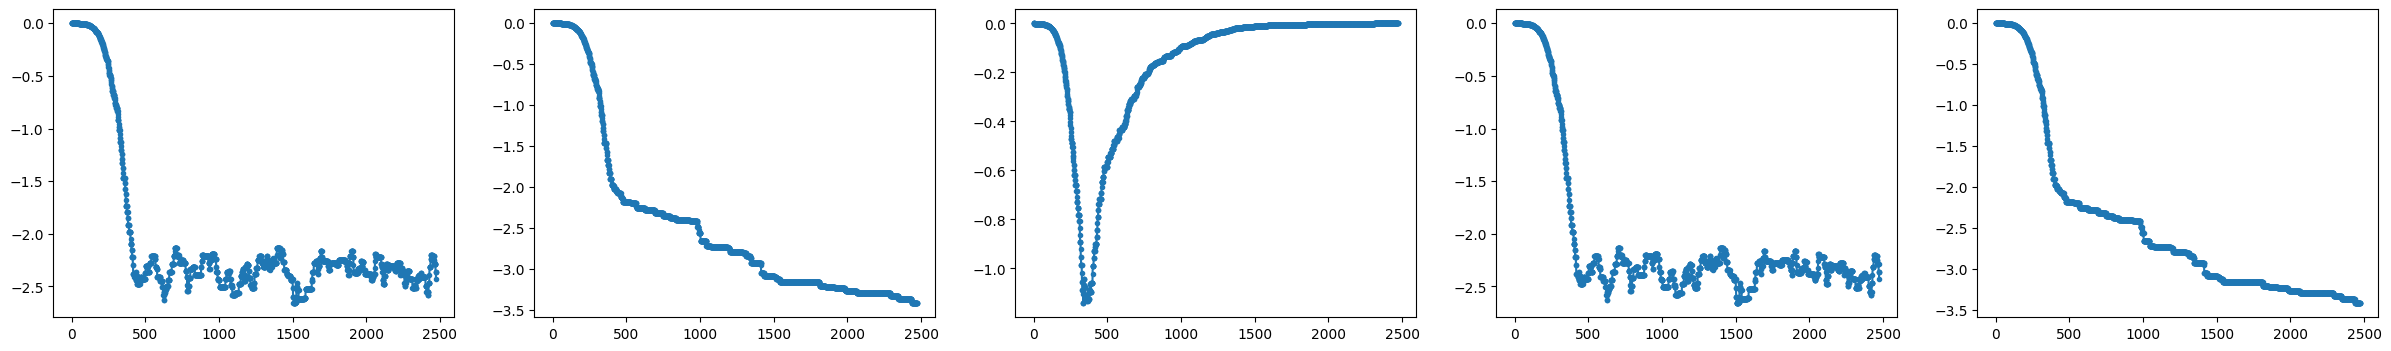

In [43]:
plot_params_iterations(params)

In [45]:
params_for_estimates = torch.stack(params[-100:]).mean(axis = 0)
# run in sample mode, without parameter modifications
observables, graphs = sampler.sample_run(graph=input_graph,
                      observables=obs,
                      params=params_for_estimates,
                      niter=niter,
                      save_every=50)

100%|██████████| 120000/120000 [00:57<00:00, 2098.02it/s]


number of accepted steps is:  15746
number of rejected samples:  104254
Mean obs:  tensor([2.8848e+01, 5.0802e-02, 1.4222e-03, 1.9232e+00, 1.4934e-03],
       dtype=torch.float64)


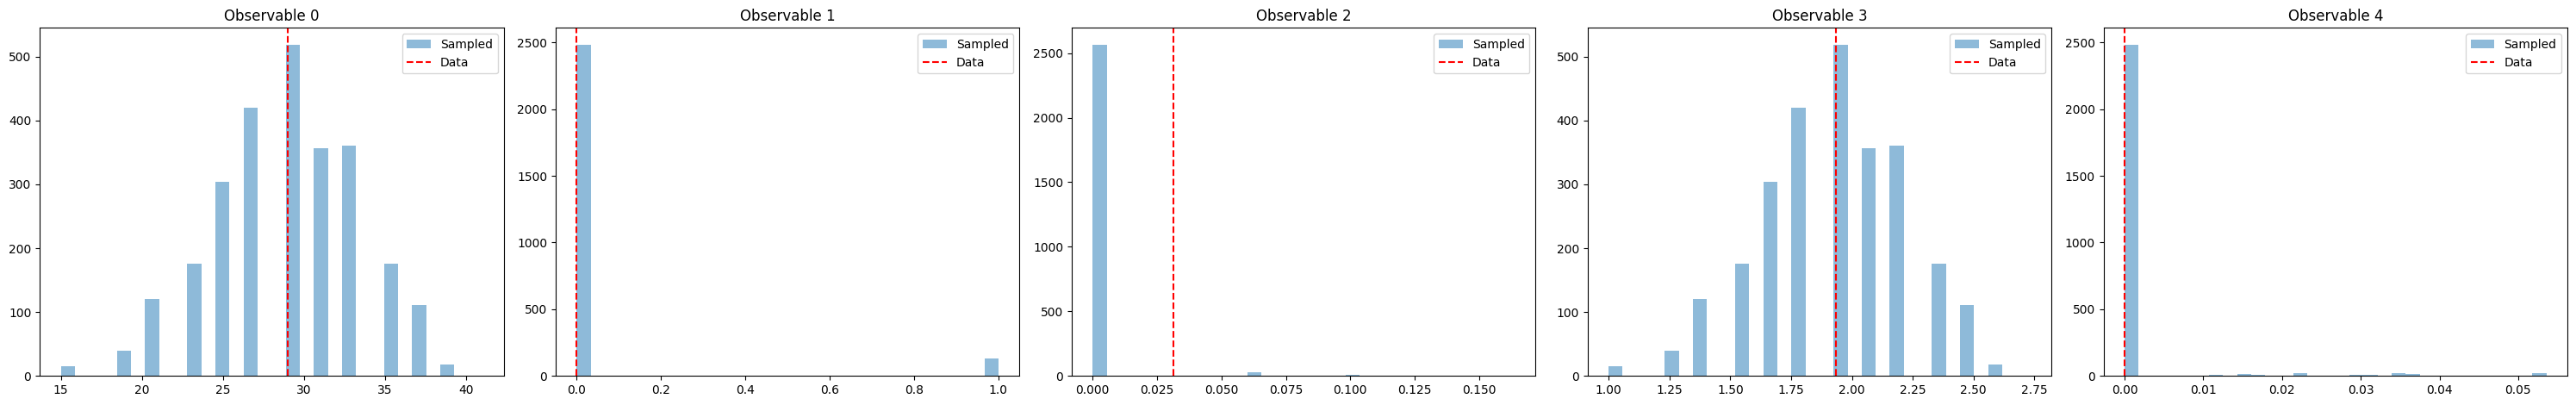

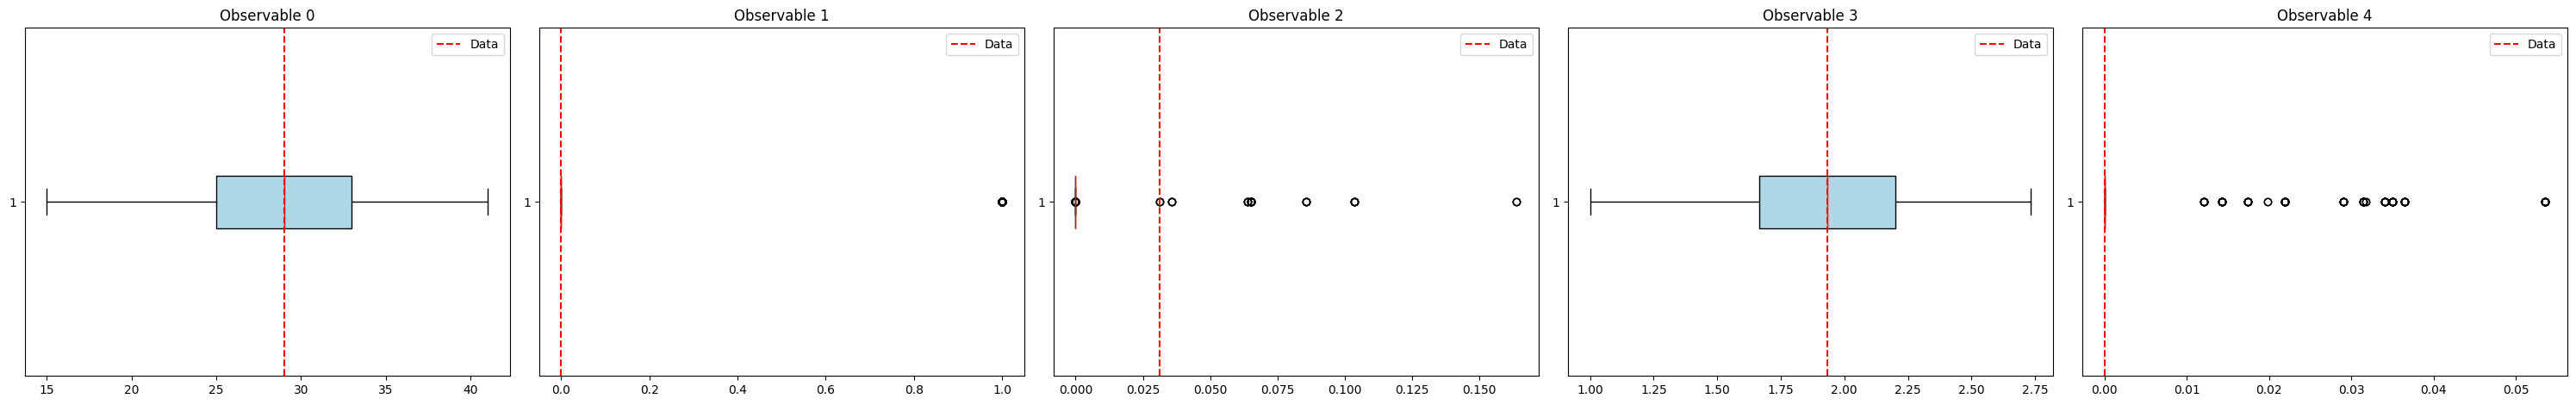

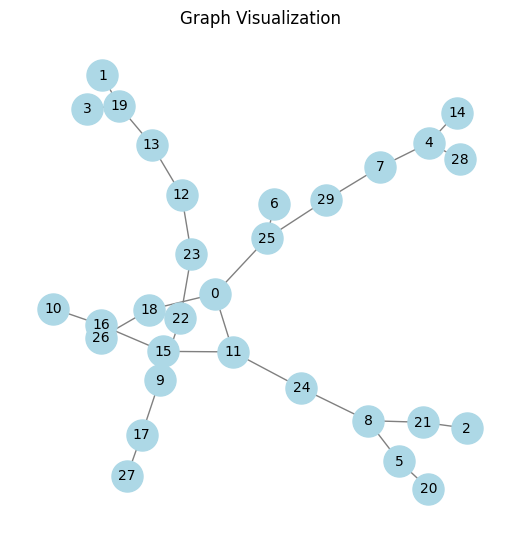

In [47]:
hist_obs_samples(observables, obs)
boxplot_obs_samples(observables, obs)
plot_graph(graphs[2])

---

In [48]:
class MyGWGSampler(GWGSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        ac = torch.linalg.eigvalsh(laplacian_matrix(mtx))[1]
        avg_degree = torch.sum(mtx, dim=1).mean()
        avg_clustering = avg_clustering_coeff(mtx)

        return(torch.stack([edges, triangles, ac, avg_degree, avg_clustering]))

betas = torch.tensor([0., 0., 0., 0., 0.], dtype=float)

GWGsampler = MyGWGSampler(backend="cuda")
obs2 = GWGsampler.observables(input_graph)

params2, graphs2 = GWGsampler.param_run(graph=input_graph,
                      observables=obs2,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

CUDA backend not available falling back to cpu


100%|██████████| 120000/120000 [04:41<00:00, 425.54it/s]

number of accepted steps is:  45262
number of rejected samples:  74738
number of effective updates is:  15087


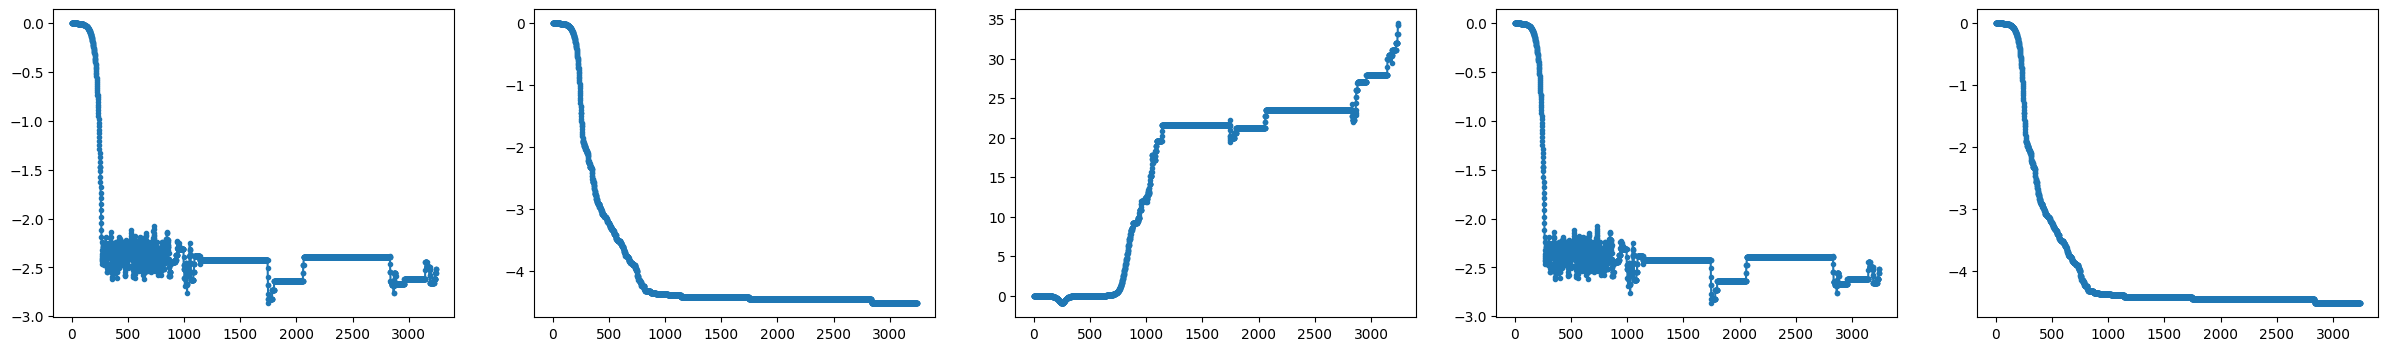

In [77]:
plot_params_iterations(params2)

In [49]:
params_for_estimates2 = torch.stack(params2[-100:]).mean(axis = 0)
# run in sample mode, without parameter modifications
observables2, graphs2 = GWGsampler.sample_run(graph=input_graph,
                      observables=obs2,
                      params=params_for_estimates,
                      niter=niter,
                      save_every=50)

100%|██████████| 120000/120000 [04:12<00:00, 475.06it/s]

number of accepted steps is:  119109
number of rejected samples:  891
Mean obs:  tensor([2.8552e+01, 3.7006e-02, 2.4620e-03, 1.9035e+00, 9.9258e-04],
       dtype=torch.float64)


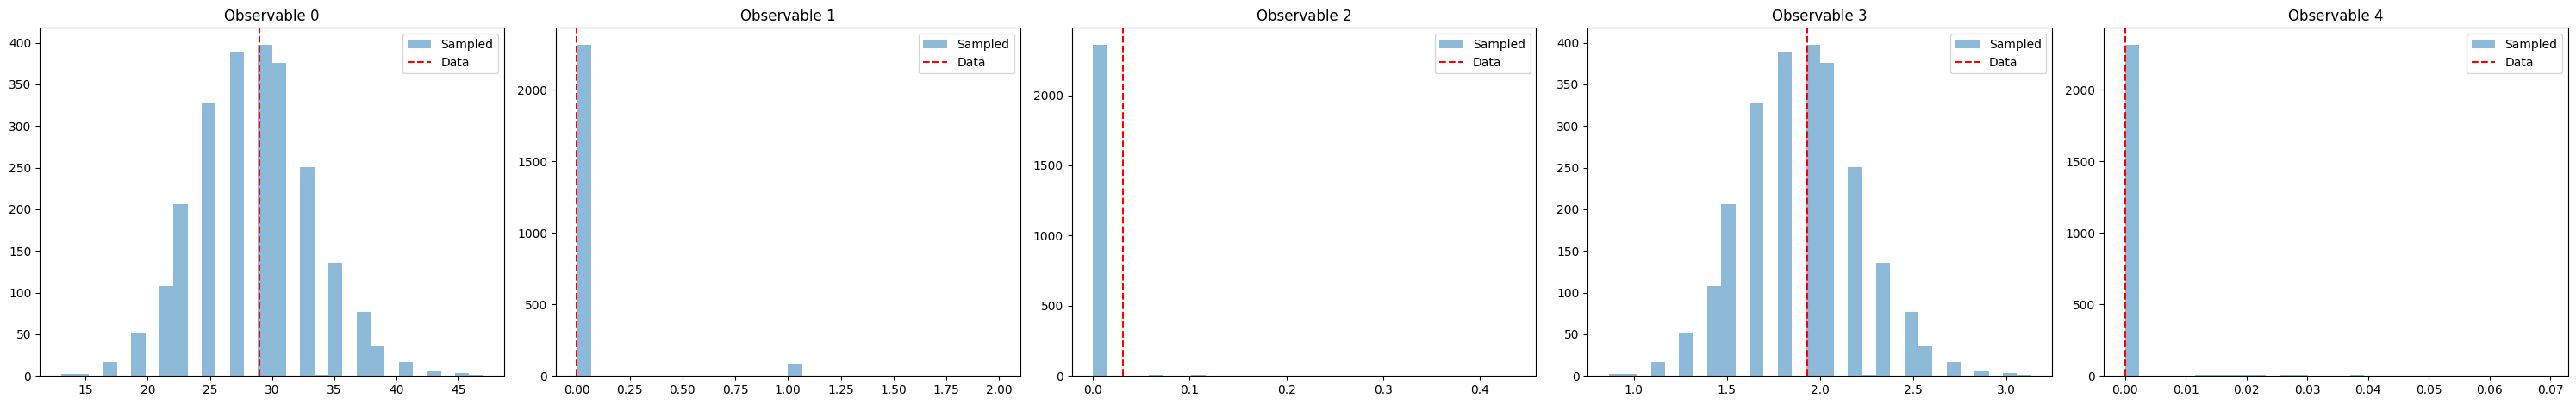

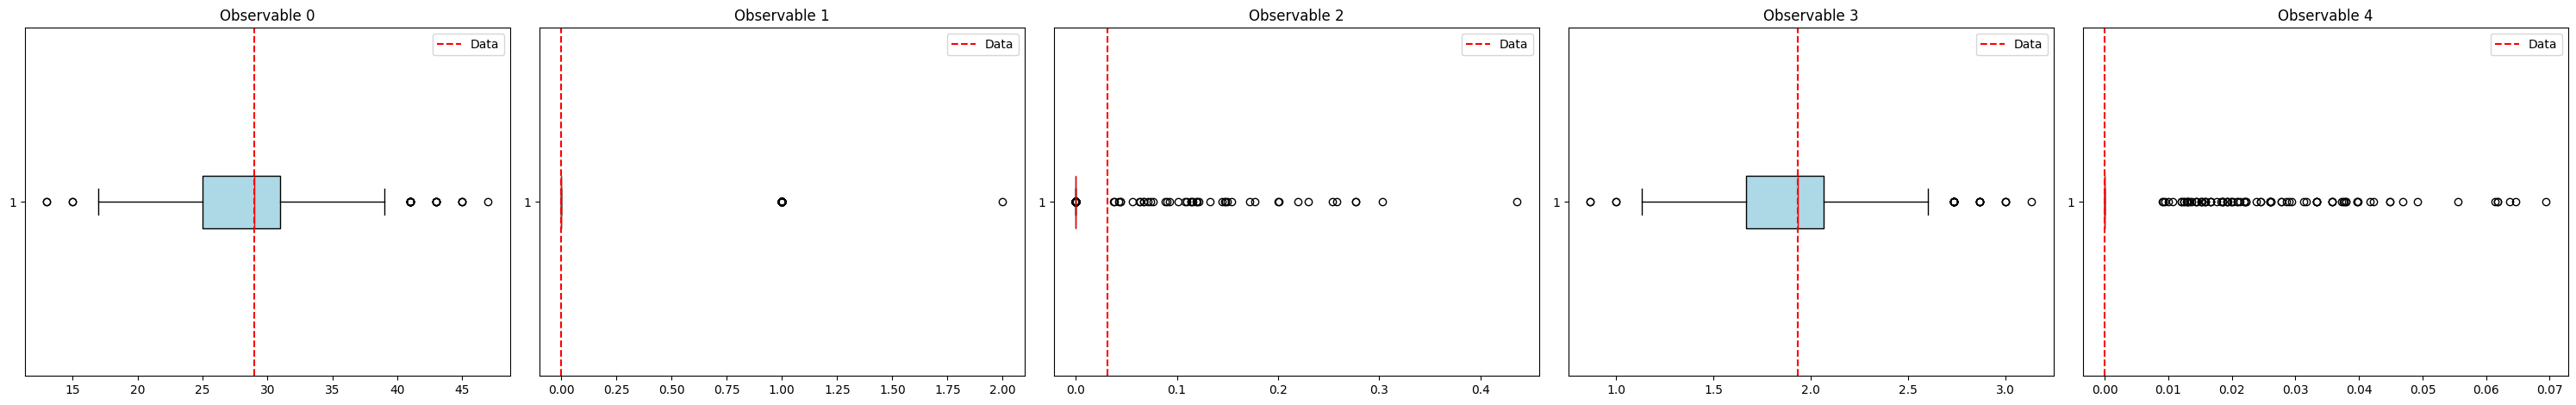

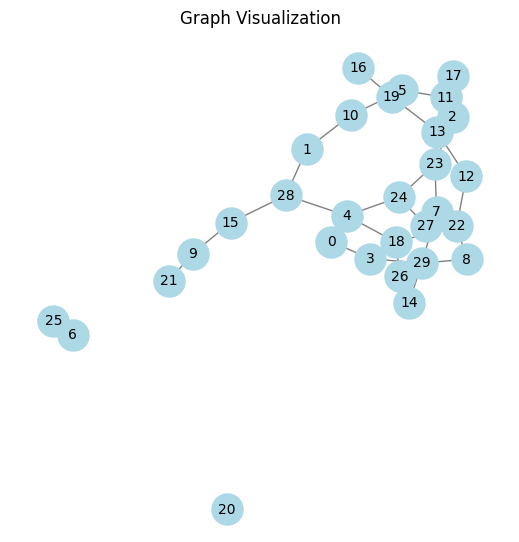

In [ ]:
hist_obs_samples(observables2, obs2)
boxplot_obs_samples(observables2, obs2)
plot_graph(graphs2[0])

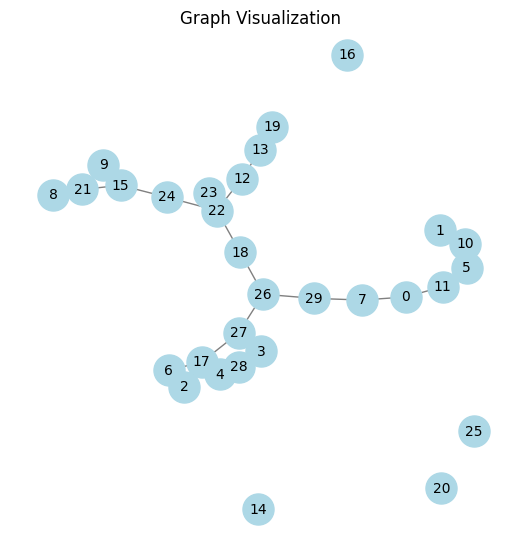

In [ ]:
plot_graph(graphs2[0])

In [70]:
nx_graph = nx.from_numpy_array(graphs2[0].numpy())
connected_components = nx.connected_components(nx_graph)
maj_graph = nx.subgraph(nx_graph, max(connected_components))

nx.is_tree(maj_graph)


True

In [79]:
c = 0
for g in graphs2:
    nx_graph = nx.from_numpy_array(graphs2[0].numpy())
    connected_components = nx.connected_components(nx_graph)
    maj_graph = nx.subgraph(nx_graph, max(connected_components))

    if nx.is_tree(maj_graph): c+=1
        
c

2405

In [76]:
mean_difference(GWGsampler, input_graph, graphs2)

tensor([0.4478, 0.0370, 0.0289, 0.0299, 0.0010], dtype=torch.float64)

In [78]:
params_for_estimates, params_for_estimates2

(tensor([-2.3761e+00, -3.3848e+00,  4.0596e-04, -2.3761e+00, -3.3848e+00],
        dtype=torch.float64),
 tensor([-2.5721, -4.5169, 30.9460, -2.5721, -4.5169], dtype=torch.float64))